In [1]:
import os
import random
from glob import glob

In [2]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# 1. Prepare data

In [4]:
data_folder = './dog_cat_dataset/train'

In [5]:
cat_img_paths = [
    os.path.join(data_folder, cat_name, name)
    for cat_name in ['cat_1', 'cat_2', 'cat_3']
    for name in os.listdir(os.path.join(data_folder, cat_name))
]

In [6]:
cat_img_paths[:10]

['./dog_cat_dataset/train/cat_1/cat.2718.jpg',
 './dog_cat_dataset/train/cat_1/cat.3406.jpg',
 './dog_cat_dataset/train/cat_1/cat.4369.jpg',
 './dog_cat_dataset/train/cat_1/cat.1211.jpg',
 './dog_cat_dataset/train/cat_1/cat.1577.jpg',
 './dog_cat_dataset/train/cat_1/cat.952.jpg',
 './dog_cat_dataset/train/cat_1/cat.3360.jpg',
 './dog_cat_dataset/train/cat_1/cat.946.jpg',
 './dog_cat_dataset/train/cat_1/cat.3374.jpg',
 './dog_cat_dataset/train/cat_1/cat.1563.jpg']

In [7]:
dog_img_paths = [
    os.path.join(data_folder, dog_name, name)
    for dog_name in ['dog_1', 'dog_2', 'dog_3']
    for name in os.listdir(os.path.join(data_folder, dog_name))
]

In [8]:
dog_img_paths[:10]

['./dog_cat_dataset/train/dog_1/dog.1753.jpg',
 './dog_cat_dataset/train/dog_1/dog.3144.jpg',
 './dog_cat_dataset/train/dog_1/dog.775.jpg',
 './dog_cat_dataset/train/dog_1/dog.3622.jpg',
 './dog_cat_dataset/train/dog_1/dog.1035.jpg',
 './dog_cat_dataset/train/dog_1/dog.1021.jpg',
 './dog_cat_dataset/train/dog_1/dog.4159.jpg',
 './dog_cat_dataset/train/dog_1/dog.3636.jpg',
 './dog_cat_dataset/train/dog_1/dog.2528.jpg',
 './dog_cat_dataset/train/dog_1/dog.761.jpg']

## Visualize data

In [9]:
def show_random_images(image_paths):
    image_paths = random.choices(image_paths, k=16)
    
    subplot_n_cols, subplot_n_rows = 4, 4

    plt.figure(figsize=(15,12))
    for idx, image_path in enumerate(image_paths):
        plt.subplot(subplot_n_rows, subplot_n_cols, idx+1)
        image = cv2.imread(os.path.join(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)

    plt.tight_layout()
    plt.show()

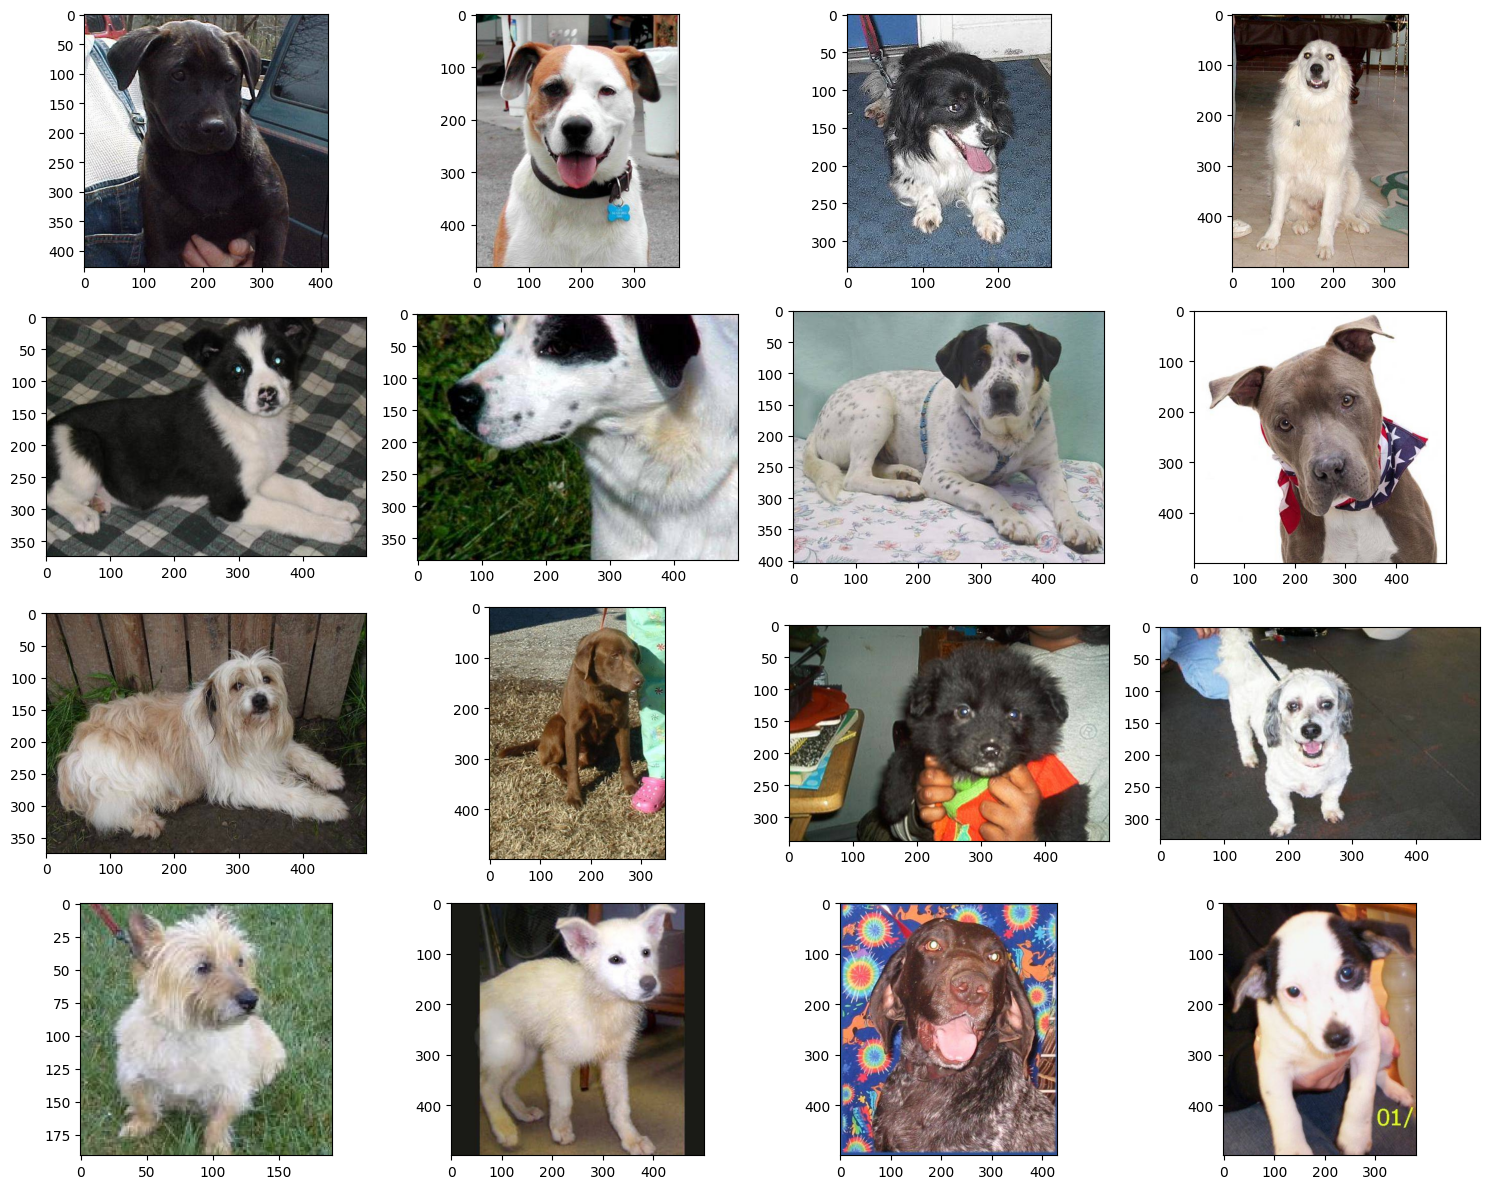

In [10]:
show_random_images(dog_img_paths)

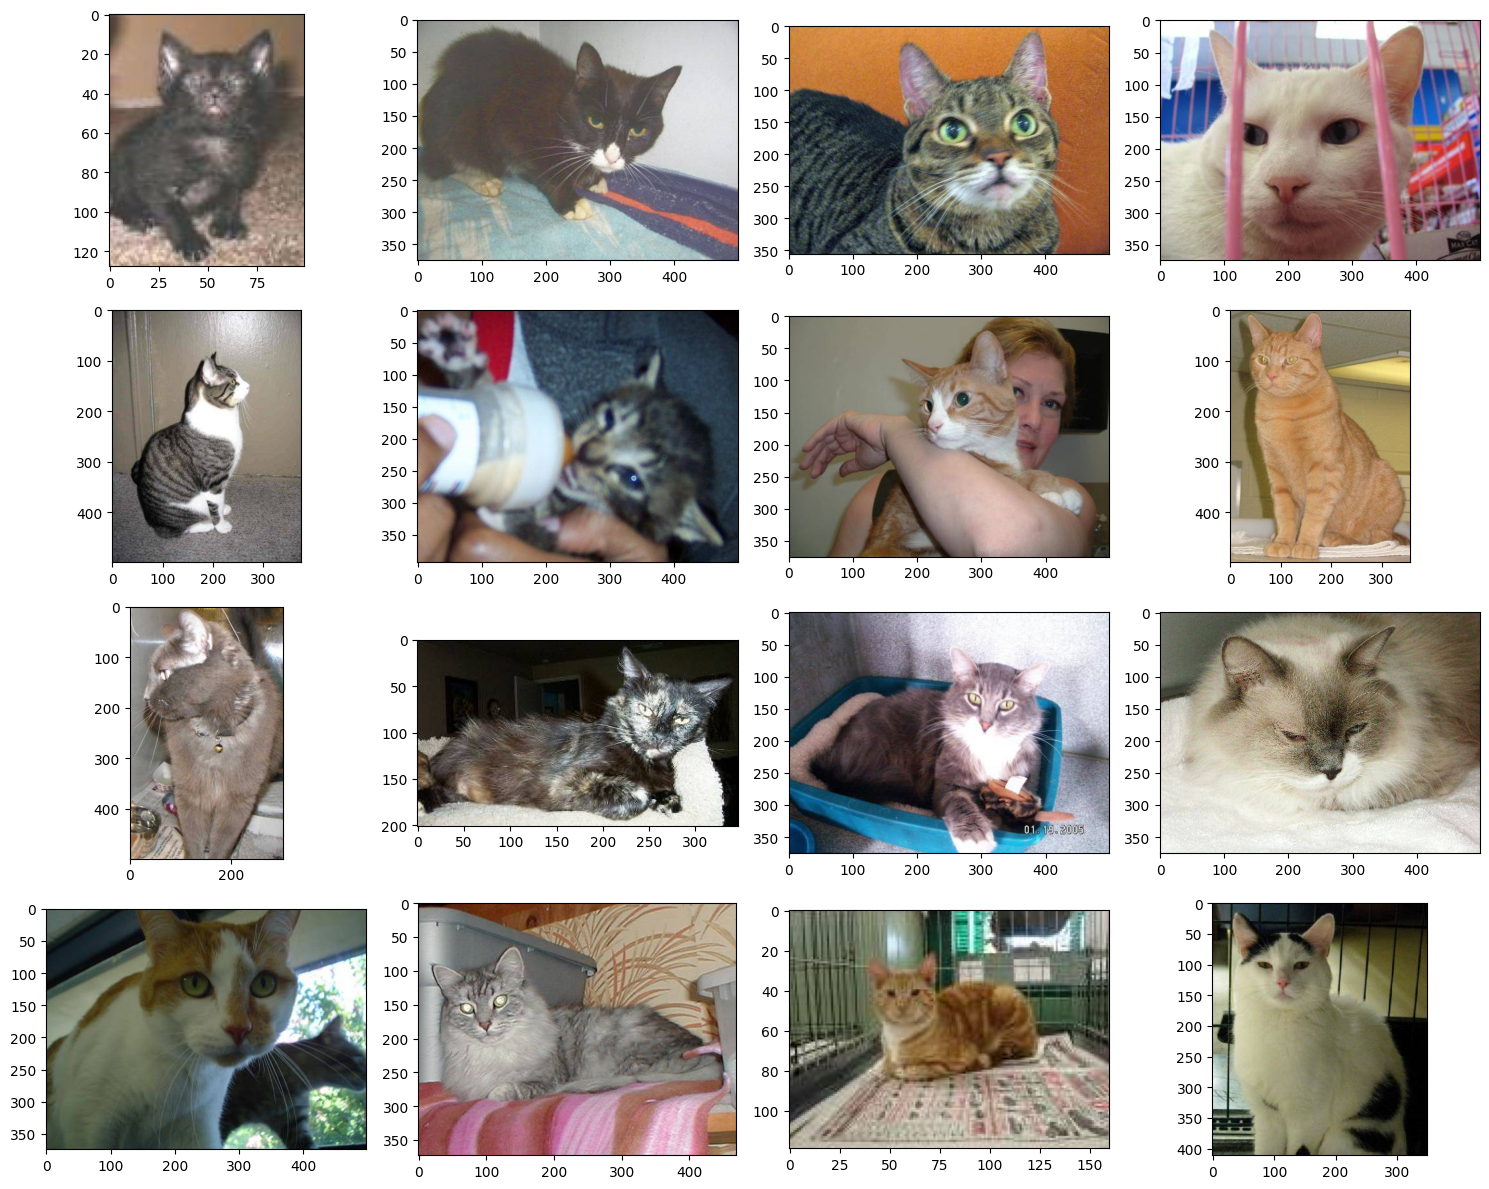

In [11]:
show_random_images(cat_img_paths)

## Split training and validation set

In [12]:
train_percent = 0.8

In [13]:
shuffle_dog_img_paths = random.sample(dog_img_paths, len(dog_img_paths))
shuffle_cat_img_paths = random.sample(cat_img_paths, len(cat_img_paths))

In [14]:
len(shuffle_dog_img_paths), len(shuffle_cat_img_paths)

(12500, 12500)

In [15]:
train_dog_img_paths = shuffle_dog_img_paths[:int(len(shuffle_dog_img_paths) * train_percent)]
val_dog_img_paths = shuffle_dog_img_paths[int(len(shuffle_dog_img_paths) * train_percent):]

In [16]:
len(train_dog_img_paths), len(val_dog_img_paths)

(10000, 2500)

In [17]:
train_cat_img_paths = shuffle_cat_img_paths[:int(len(shuffle_cat_img_paths) * train_percent)]
val_cat_img_paths = shuffle_cat_img_paths[int(len(shuffle_cat_img_paths) * train_percent):]

In [18]:
len(train_cat_img_paths), len(val_cat_img_paths)

(10000, 2500)

In [19]:
img_train_paths = train_dog_img_paths + train_cat_img_paths
img_val_paths = val_dog_img_paths + val_cat_img_paths

In [20]:
# IMAGE
len(img_train_paths), len(img_val_paths)

(20000, 5000)

In [21]:
# LABEL
# DOG = 0, CAT = 1
label_train = ['dog'] * len(train_dog_img_paths) + ['cat'] * len(train_cat_img_paths)
label_val = ['dog'] * len(val_dog_img_paths) + ['cat'] * len(val_cat_img_paths)

len(label_train), len(label_val)

(20000, 5000)

# Keras Image Data Generator

In [22]:
train_df = pd.DataFrame(data={
    'image_path': img_train_paths,
    'label': label_train
})
train_df

image_path label
0      ./dog_cat_dataset/train/dog_1/dog.2415.jpg   dog
1      ./dog_cat_dataset/train/dog_2/dog.9632.jpg   dog
2      ./dog_cat_dataset/train/dog_2/dog.8135.jpg   dog
3      ./dog_cat_dataset/train/dog_1/dog.3939.jpg   dog
4      ./dog_cat_dataset/train/dog_1/dog.4873.jpg   dog
...                                           ...   ...
19995   ./dog_cat_dataset/train/cat_1/cat.180.jpg   cat
19996  ./dog_cat_dataset/train/cat_1/cat.4351.jpg   cat
19997  ./dog_cat_dataset/train/cat_2/cat.9982.jpg   cat
19998  ./dog_cat_dataset/train/cat_1/cat.3306.jpg   cat
19999  ./dog_cat_dataset/train/cat_2/cat.7947.jpg   cat

[20000 rows x 2 columns]

In [23]:
val_df = pd.DataFrame(data={
    'image_path': img_val_paths,
    'label': label_val
})
val_df

image_path label
0     ./dog_cat_dataset/train/dog_3/dog.12003.jpg   dog
1      ./dog_cat_dataset/train/dog_2/dog.8614.jpg   dog
2     ./dog_cat_dataset/train/dog_3/dog.11666.jpg   dog
3     ./dog_cat_dataset/train/dog_3/dog.11972.jpg   dog
4      ./dog_cat_dataset/train/dog_2/dog.7035.jpg   dog
...                                           ...   ...
4995   ./dog_cat_dataset/train/cat_2/cat.8628.jpg   cat
4996   ./dog_cat_dataset/train/cat_2/cat.9562.jpg   cat
4997   ./dog_cat_dataset/train/cat_2/cat.6114.jpg   cat
4998   ./dog_cat_dataset/train/cat_2/cat.5106.jpg   cat
4999   ./dog_cat_dataset/train/cat_2/cat.8918.jpg   cat

[5000 rows x 2 columns]

In [24]:
IMAGE_SIZE = 64
BATCH_SIZE = 4

In [25]:
train_dataset = ImageDataGenerator().flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 20000 validated image filenames belonging to 2 classes.


In [26]:
val_dataset = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE * 2,
    class_mode='binary'
)

Found 5000 validated image filenames belonging to 2 classes.


# 2. Prepare model

In [27]:
model = Sequential([
    Conv2D(filters=8, kernel_size=3, activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    Conv2D(filters=8, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2, strides=2),

    Flatten(),
    Dense(units=256, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=1, activation='sigmoid')
])

model.summary()

/Users/minhhuunguyen/REPOSITORY/minhhuunguyen.github.io/posts/ai-lectures/venv/keras_tf_venv/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231,545 (904.47 KB)

 Trainable params: 231,049 (902.54 KB)

 Non-trainable params: 496 (1.94 KB)

# 3. Compile and train model

In [28]:
bce_loss = BinaryCrossentropy()

In [29]:
opt = SGD(learning_rate=0.001)

In [30]:
model.compile(loss=bce_loss, optimizer=opt, metrics=[BinaryAccuracy()])

In [31]:
NUM_EPOCH = 20

In [32]:
history = model.fit(
    x=train_dataset,
    epochs=NUM_EPOCH,
    validation_data=val_dataset,
    shuffle=True
)

Epoch 1/20


/Users/minhhuunguyen/REPOSITORY/minhhuunguyen.github.io/posts/ai-lectures/venv/keras_tf_venv/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - binary_accuracy: 0.5795 - loss: 0.7643 - val_binary_accuracy: 0.7018 - val_loss: 0.5773
Epoch 2/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - binary_accuracy: 0.6990 - loss: 0.5718 - val_binary_accuracy: 0.7362 - val_loss: 0.5286
Epoch 3/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - binary_accuracy: 0.7384 - loss: 0.5213 - val_binary_accuracy: 0.7400 - val_loss: 0.5239
Epoch 4/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - binary_accuracy: 0.7650 - loss: 0.4806 - val_binary_accuracy: 0.7628 - val_loss: 0.4968
Epoch 5/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - binary_accuracy: 0.7821 - loss: 0.4589 - val_binary_accuracy: 0.7790 - val_loss: 0.4631
Epoch 6/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - binary_accuracy: 0.7949 - loss: 0.4330 - val_binary_accuracy: 0.7768 - val_loss: 0.4694
Epoch 7/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - binary_accuracy: 0.8154 - loss: 0.4063 - val_binary_accuracy: 0.7720 - val_loss: 0.4

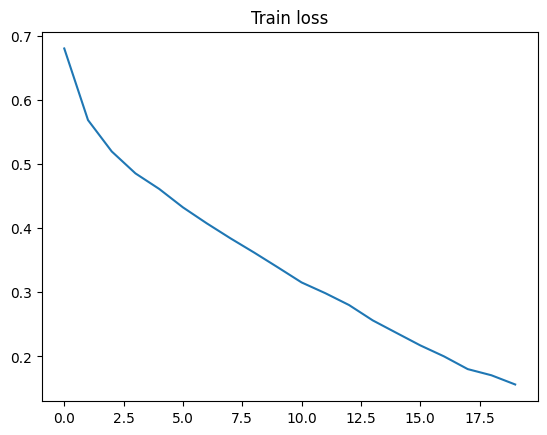

In [33]:
sns.lineplot(x=range(NUM_EPOCH), y=history.history['loss'])
plt.title('Train loss')
plt.show()

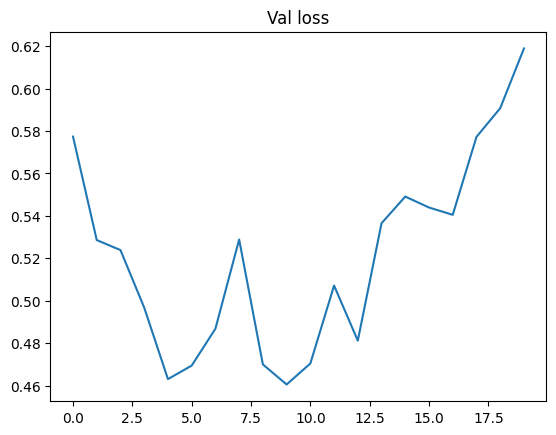

In [34]:
sns.lineplot(x=range(NUM_EPOCH), y=history.history['val_loss'])
plt.title('Val loss')
plt.show()

In [35]:
pred_prob = model.predict(val_dataset)
pred_prob

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


array([[0.5421772 ],
       [0.9909296 ],
       [0.04244011],
       ...,
       [0.00128018],
       [0.99567133],
       [0.01659704]], dtype=float32)

In [36]:
CONFIDENCE_THRESHOLD = 0.5

In [37]:
y_pred = np.where(pred_prob > CONFIDENCE_THRESHOLD, 1, 0)
y_pred = y_pred.squeeze()
y_pred, y_pred.shape

(array([1, 1, 0, ..., 0, 1, 0]), (5000,))

In [38]:
y_label_idx = [0 if i == 'dog' else 1 for i in val_df.label.to_list()]
y_label_idx

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [39]:
print(classification_report(y_label_idx, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.52      0.50      2500
           1       0.49      0.46      0.48      2500

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.49      5000
weighted avg       0.49      0.49      0.49      5000

